In [67]:
import shap
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Load and pre-process data

In [68]:
df = pd.read_csv("data/stex.csv", encoding = "ISO-8859-1")
df.head()

,L1,C,L1L2,L2,AaA,LoR,Edu.day,Sex,Family,ISO639.3,Enroll,Speaking,morph,lex,new_feat,new_sounds
0,Afrikaans,SouthAfrica,AfrikaansEnglish,English,25,0,4.0,Female,Indo-European,afr,93,496,NaN,0.010463,NaN,NaN
1,Afrikaans,SouthAfrica,AfrikaansGerman,German,47,2,4.0,Male,Indo-European,afr,93,542,NaN,0.010463,NaN,NaN
2,Afrikaans,SouthAfrica,AfrikaansMonolingual,Monolingual,23,23,3.0,Female,Indo-European,afr,93,585,NaN,0.010463,NaN,NaN
3,Afrikaans,SouthAfrica,AfrikaansMonolingual,Monolingual,42,2,2.0,Female,Indo-European,afr,93,521,NaN,0.010463,NaN,NaN
4,Afrikaans,SouthAfrica,AfrikaansMonolingual,Monolingual,22,19,3.0,Female,Indo-European,afr,93,639,NaN,0.010463,NaN,NaN


In [69]:
germanic_languages = [
    "English", "German", "Dutch", "Afrikaans", "Yiddish", "Frisian",
    "Icelandic", "Norwegian", "Swedish", "Danish", "Faroese", "Luxembourgish",
    "Scots", "Elfdalian"
]

indo_european = [lang for lang in df[df['Family']=='Indo-European']['L1'].value_counts().keys() if lang not in germanic_languages]

def l_modified(language):
    if language == 'Monolingual':
        return language
    if language in germanic_languages:
        return "Germanic"
    if language in indo_european:
        return 'Indo-European (Non-Germanic)'
    return 'Non-Indo-European'

In [70]:
def pre_process_df(df):
    df['L1_mod'] = df['L1'].apply(lambda row: l_modified(row))
    df['L2_mod'] = df['L2'].apply(lambda row: l_modified(row))
    df['L2_mod'] = df['L2_mod'].apply(lambda row: row if row in ['Germanic', 'Monolingual'] else 'Other')
    to_drop = ['L1', 'C', 'L1L2', 'L2', 'Sex', 'Family', 'ISO639.3', 
               'morph', 'lex', 'new_feat', 'new_sounds']
    df = df.drop(to_drop, axis=1)
    df = df.dropna().reset_index(drop=True)
    return df

In [71]:
df = pre_process_df(df)
df

,AaA,LoR,Edu.day,Enroll,Speaking,L1_mod,L2_mod
0,25,0,4.0,93,496,Germanic,Germanic
1,47,2,4.0,93,542,Germanic,Germanic
2,23,23,3.0,93,585,Germanic,Monolingual
3,42,2,2.0,93,521,Germanic,Monolingual
4,22,19,3.0,93,639,Germanic,Monolingual
...,...,...,...,...,...,...,...
50221,29,8,3.0,35,514,Non-Indo-European,Germanic
50222,28,2,4.0,35,505,Non-Indo-European,Germanic
50223,27,12,3.0,35,502,Non-Indo-European,Germanic
50224,26,2,3.0,35,426,Non-Indo-European,Germanic


In [72]:
df.L2_mod.unique()

array(['Germanic', 'Monolingual', 'Other'], dtype=object)

# Load pre-processor and model

In [73]:
# Load the trained model
model_filename = "xgboost_best_model.pkl"
with open(model_filename, "rb") as file:
    model = pickle.load(file)

# Load the preprocessor
preprocessor_filename = "preprocessor.pkl"
with open(preprocessor_filename, "rb") as file:
    preprocessor = pickle.load(file)

print("Model and preprocessor successfully loaded!")

Model and preprocessor successfully loaded!


# Process data

In [74]:
df_processed = preprocessor.transform(df)

In [75]:
pd.DataFrame(df_processed, columns=model.feature_names_in_)

,AaA,LoR,Enroll,Edu.day,L1_mod_Indo-European (Non-Germanic),L1_mod_Non-Indo-European,L2_mod_Monolingual,L2_mod_Other
0,-0.125,-1.000000,0.212121,3.0,0.0,0.0,0.0,0.0
1,2.625,-0.333333,0.212121,3.0,0.0,0.0,0.0,0.0
2,-0.375,6.666667,0.212121,2.0,0.0,0.0,1.0,0.0
3,2.000,-0.333333,0.212121,1.0,0.0,0.0,1.0,0.0
4,-0.500,5.333333,0.212121,2.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
50221,0.375,1.666667,-1.545455,2.0,0.0,1.0,0.0,0.0
50222,0.250,-0.333333,-1.545455,3.0,0.0,1.0,0.0,0.0
50223,0.125,3.000000,-1.545455,2.0,0.0,1.0,0.0,0.0
50224,0.000,-0.333333,-1.545455,2.0,0.0,1.0,0.0,0.0


# Make predictions

In [76]:
predictions = model.predict(df_processed)

In [77]:
rmse_test = np.sqrt(mean_squared_error(df.Speaking.values, predictions))
r2_test = r2_score(df.Speaking.values, predictions) 

In [78]:
rmse_test, r2_test

(30.877385233330614, 0.3368678484555584)

# Make predictions on a single observation

In [79]:
def predict_dutch_proficiency(observation):
    """
    Given a single observation (dictionary or DataFrame), this function:
    - Loads the trained model & preprocessor
    - Preprocesses the observation
    - Makes a prediction
    - Returns the predicted Dutch speaking proficiency score
    """
    with open("xgboost_best_model.pkl", "rb") as file:
        model = pickle.load(file)

    with open("preprocessor.pkl", "rb") as file:
        preprocessor = pickle.load(file)

    # Convert observation to DataFrame if needed
    if isinstance(observation, dict):
        observation = pd.DataFrame([observation])  # Convert single dictionary to DataFrame

    observation_processed = preprocessor.transform(observation)
    observation_processed = pd.DataFrame(observation_processed, columns=model.feature_names_in_)

    prediction = model.predict(observation_processed)[0]  # Extract the single prediction
    
    # Compute SHAP values
    explainer = shap.Explainer(model)
    shap_values = explainer(observation_processed)

    # Generate SHAP plot
    shap.waterfall_plot(shap_values[0])
    plt.show()

    return prediction

For reference, Speaking:

    mean       517.621451
    std         37.917945
    min        270.000000
    max        685.000000

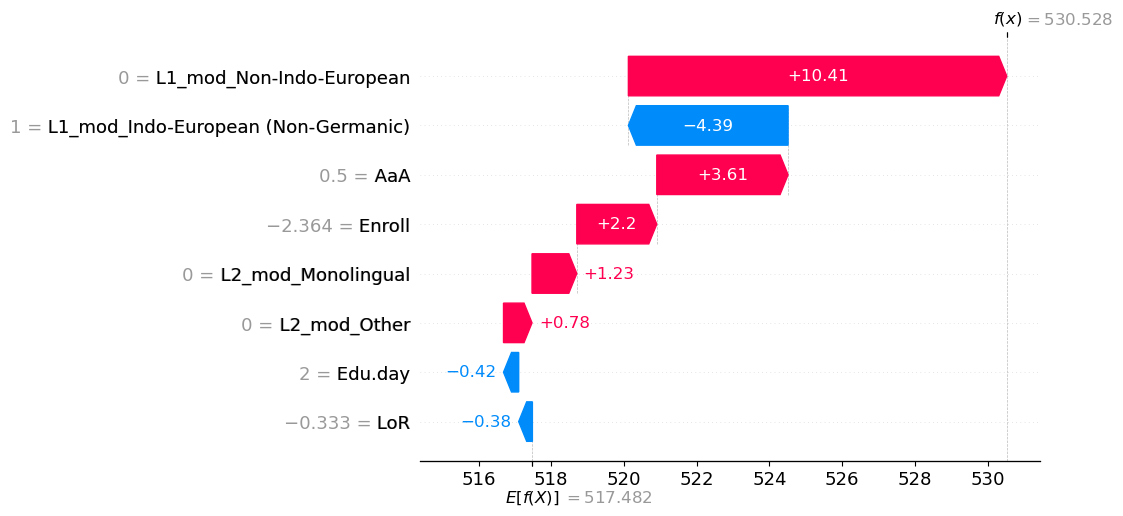

Predicted Dutch Speaking Proficiency Score: 530.53


In [80]:
# Example input: A single new person's data
new_observation = {
    "AaA": 30,
    "LoR": 2,
    "Edu.day": 3.0,
    "Enroll": 8,
    "L1_mod": 'Indo-European (Non-Germanic)',
    "L2_mod": 'Germanic'
}

predicted_score = predict_dutch_proficiency(new_observation)
print(f"Predicted Dutch Speaking Proficiency Score: {predicted_score:.2f}")

# Simulation-Based Policy Testing for Language Learning Strategies
Use the trained XGBoost model to predict speaking proficiency if:
- Enroll is increased by 50%
- LoR is doubled

In [49]:
df_simulated = df.copy()
df_simulated["Enroll"] *= 1.5  
df_simulated["LoR"] *= 2

In [53]:
# Predict speaking proficiency in new scenario
df_pr_sm = preprocessor.transform(df_simulated)
y_simulated = model.predict(df_pr_sm)

In [55]:
# Compare with actual test results
print("Mean Predicted Score Before:", df.Speaking.mean())
print("Mean Predicted Score After Policy Change:", y_simulated.mean())

Mean Predicted Score Before: 517.6214510412933
Mean Predicted Score After Policy Change: 527.15234


# Real-Time AI Tool for Migrant Language Learning Success

Build an AI tool that predicts Dutch language success for new migrants and gives personalized suggestions based on the profile

`python app.py`

http://127.0.0.1:5001/